So we define two things $A$ and $B$, and then we think about the expected value of $A$ and $B$. We start off with these being two normal distributions centered at 0. 

This was inspired by talking to Dr. Rangel at Caltech.

In [7]:
import bayespy
import matplotlib.pyplot as plt
import numpy as np
import time
import pygal
# then we define two normal distributions centered at 0, A and B
P_A = pm.Normal.dist(0, 5)
P_B = pm.Normal.dist(0, 5)

# evaluate the distributions at 1001 points between -15 and 15
x_vals = np.linspace(-15, 15, 1001)
density_A = pm.math.exp(P_A.logp(x_vals)).eval()
density_B = pm.math.exp(P_B.logp(x_vals)).eval()


# Set up a brutalist style plot
# Create a pygal line chart with minimalist style
line_chart = pygal.Line(
    width=800,
    height=500,
    style=pygal.style.Style(
        background='white',
        plot_background='white',
        foreground='black',
        foreground_strong='black',
        foreground_subtle='black',
        opacity='.6',
        opacity_hover='.9',
        transition='400ms ease-in',
        colors=('#E14D0E', '#e1b60e')  # Changed second color to yellow
    )
)

# Configure chart
line_chart.title = ''
line_chart.x_title = 'x'
line_chart.y_title = 'Density'

# Add data points
line_chart.x_labels = [f'{x:.1f}' for x in x_vals[::50]]  # Add fewer labels for clarity
line_chart.add('A', density_A[::50])  # Sample fewer points for smoother rendering
line_chart.add('B', density_B[::50])

# Render the chart
display(line_chart)


AttributeError: 'TensorVariable' object has no attribute 'logp'

We have two things. We want to update on these two things. Let's say that our two things are "apple" and "orange". Each of these have some features (as defined by the brain), and with some *ground truth* magnitude. However, the brain can only probabilistically sample the magnitude of these features.

We assume in this case that there are $5$ features that are present, that we then sample.

The feature vector for each object $o \in O$ is a function $F: O \to \mathbb{R}^N$, with $N = 5$ in our case. 

From a CS perspective, think of this as an "embeddings" vector, but where embeddings are preferentially sparse. Noteably, we throw away the ability to do cosine similarity, but we gain other useful and interpretable properties.

I'll generate two vectors of random, power law distributed values.



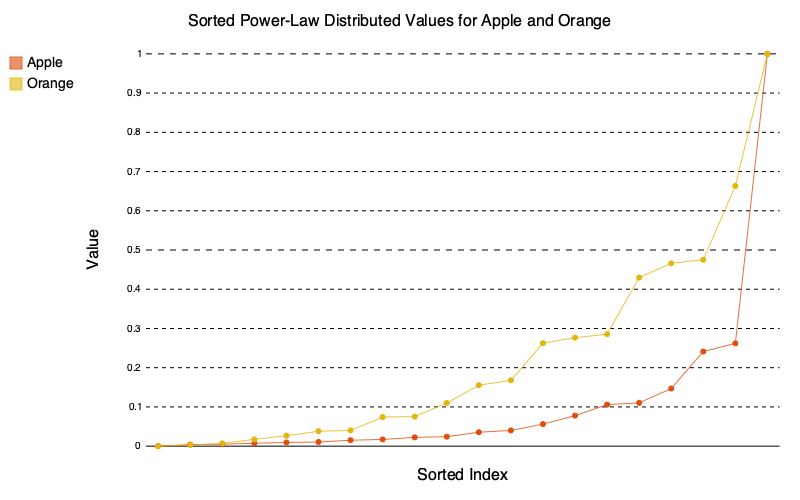

In [3]:
import numpy as np
import matplotlib.pyplot as plt

n = 20

def generate_power_law_vector(length, alpha=2.5):
    """
    Generate a random vector with power-law distributed values.
    
    :param length: Length of the vector
    :param alpha: Power-law exponent (default is 2.5)
    :return: Numpy array of power-law distributed values
    """
    # Generate uniform random numbers
    u = np.random.uniform(0, 1, length)
    
    # Transform to power-law distribution
    x = (1 - u) ** (-1 / (alpha - 1))
    
    # Normalize to [0, 1] range
    x_normalized = (x - x.min()) / (x.max() - x.min())
    
    return x_normalized

# Generate two power-law distributed vectors
vector_apple = generate_power_law_vector(n)
vector_orange = generate_power_law_vector(n)

objects_features = [vector_apple, vector_orange]


line_chart = pygal.Line(
    width=800,
    height=500,
    style=pygal.style.Style(
        background='white',
        plot_background='white',
        foreground='black',
        foreground_strong='black',
        foreground_subtle='black',
        opacity='.6',
        opacity_hover='.9',
        transition='400ms ease-in',
        colors=('#E14D0E', '#e1b60e')  # Orange and yellow colors
    )
)

# Configure chart
line_chart.title = 'Sorted Power-Law Distributed Values for Apple and Orange'
line_chart.x_title = 'Sorted Index'
line_chart.y_title = 'Value'

# Add data points (removed custom colors since they're defined in the style)
line_chart.add('Apple', sorted(vector_apple))
line_chart.add('Orange', sorted(vector_orange))

display(line_chart)

We then assign each feature a weight, which is a normal distribution $(\mu_i, \sigma_i)$, both of which are sampled from a normal distribution.

In [3]:
feature_weights = [] # tuple of (mu, sigma)

for i in range(n):
    mu = np.random.normal(0, 1)
    sigma = abs(np.random.normal(0, 1))
    feature_weights.append((mu, sigma))

rounded_feature_weights = [(round(mu, 2), round(sigma, 2)) for mu, sigma in feature_weights]
print(rounded_feature_weights)

[(0.2, 0.22), (-0.3, 0.72), (0.28, 0.13), (-0.3, 0.61), (0.94, 0.49), (-1.39, 1.23), (-0.71, 0.47), (1.76, 1.58), (-0.81, 1.64), (-0.59, 0.74), (1.22, 0.76), (-1.67, 0.2), (0.6, 0.32), (-0.04, 0.53), (0.23, 0.47), (0.49, 2.35), (-0.13, 0.15), (-1.23, 0.9), (-1.18, 0.55), (-0.56, 0.56)]


What we now do is that we sample the feature distributions. The simulation *attends* to one of the objects, and then samples the values of the features, as a random point on the normal distribution. There is a true value of feature distribution, and the brain maintains an "experimental" feature distribution. This is the main decision loop.

True feature values: [0.08871, 0.12078, 0.02937, 0.09712, 0.3887, 0.24996, 0.09406, 0.00776, 0.02385, 0.06707, 0.01325, 0.14967, 0.21336, 0.00533, 1.0, 0.00218, 0.05759, 0.16531, 0.00457, 0.0]
Updating


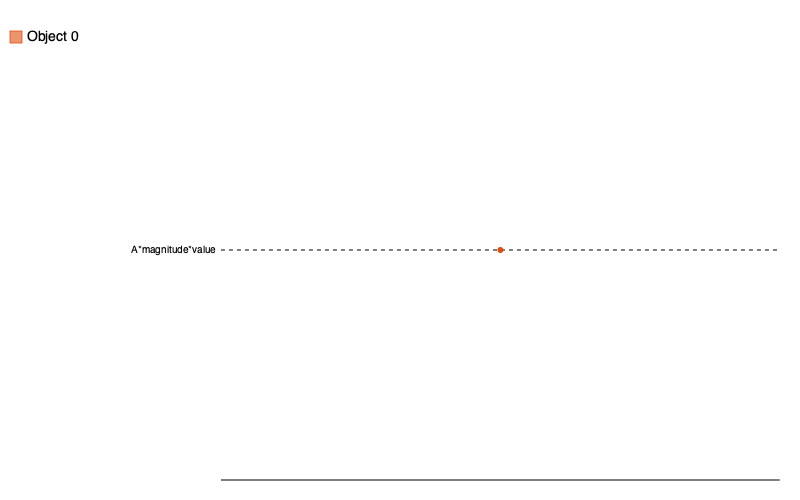

A*magnitude*value


In [15]:
from scipy.stats import norm
import sympy

currently_attending = 0 # boolean 0 or 1

experimental_feature_values = [[0] * n, [0] * n]
experimental_num_samples = [0, 0]
experimental_object_values = [P_A, P_B]

print(f"True feature values: {list(map(lambda x: float(round(x, 5)), objects_features[currently_attending]))}")

tick_length = 0.01 

while True:
    # sample one point from each feature on the object
    true_feature_values = objects_features[currently_attending]
    for i in range(n):
        sampled_value = np.random.normal(objects_features[currently_attending][i], objects_features[currently_attending][i])
        experimental_feature_values[currently_attending][i] += sampled_value
        
    experimental_num_samples[currently_attending] += 1

    largest_feature_raw = max(experimental_feature_values[currently_attending])
    largest_feature = max(experimental_feature_values[currently_attending]) / experimental_num_samples[currently_attending]
    second_largest_feature = sorted(experimental_feature_values[currently_attending])[-2] / experimental_num_samples[currently_attending]

    largest_feature_std = largest_feature / np.sqrt(experimental_num_samples[currently_attending])
    largest_feature_index = experimental_feature_values[currently_attending].index(largest_feature_raw)
    second_largest_feature_std = second_largest_feature / np.sqrt(experimental_num_samples[currently_attending])

    d = abs(largest_feature - second_largest_feature) / np.sqrt(largest_feature_std**2 + second_largest_feature_std**2)
    p_value = 2 * norm.cdf(- d / 2)

    if p_value < 0.05:
        print("Updating")
        feature_magnitude = experimental_feature_values[currently_attending][largest_feature_index] / experimental_num_samples[currently_attending]
        feature_magnitude_std = np.sqrt(feature_magnitude) / experimental_num_samples[currently_attending]
        feature_value, feature_value_std = feature_weights[largest_feature_index]

        # we create this new thing called the update value
        # this is equal to the feature magnitude (as a distribution) times the feature value (as a distribution)
        magnitude_dist = sympy.stats.Normal('magnitude', feature_magnitude, feature_magnitude_std)
        value_dist = sympy.stats.Normal('value', feature_value, feature_value_std)

        update_value = magnitude_dist * value_dist

        # we then should update the object value distribution, bayesianly
        current_object_value = experimental_object_values[currently_attending]

        # we then update the object value distribution
        # we do P(A) = P(A) * P(update_value | A)
        # and then normalize
        experimental_object_values[currently_attending] = current_object_value * update_value

        line_chart = pygal.Line(
            width=800,
            height=500,
            style=pygal.style.Style(
                background='white',
                plot_background='white',
                foreground='black',
                foreground_strong='black',
                foreground_subtle='black',
                opacity='.6',
                opacity_hover='.9',
                transition='400ms ease-in',
                colors=('#E14D0E', '#e1b60e')  # Orange and yellow colors
            )
        )

        # plot the object values
        x_vals = np.linspace(-15, 15, 1001)
        value = lambdify(x, experimental_object_values[currently_attending])(x_vals)
        line_chart.add(f'Object {currently_attending}', value)
        display(line_chart)
        print(value)
        break
        

    time.sleep(tick_length)
    